In [1]:
# 该版本采用的是常老师提供的数据进行计算

# overhead
import pandas as pd
import numpy as np
import os
import re
import jieba
from nltk import FreqDist
from collections import Counter
from matplotlib import pyplot as plt
plt.style.use(['ieee', 'no-latex'])
plt.rcParams['font.family'] = "Times New Roman"

In [2]:
# 定义一个包含描述极端天气的词典
dict_weather = {
    '高温', '海平面上升', '洪水', '干旱','天气','恶劣',
    '雨','雪','风','雷','雾','沙尘','沙尘暴','雾霾','霾',
    '温','湿','冷','阴','高温','低温', 
    '冲击','影响'
    }

In [3]:
df = pd.read_excel(r"C:\Users\Think\OneDrive\学习\py_ass\data\sample.xlsx")

# 使用 str.contains() 方法筛选出包含在词典中的文本
df["body"] = df["body"].str.replace('[^\u4e00-\u9fa5]+', '')  # 删除非汉字项
df['sep'] = df['body'].apply(lambda x: ' '.join(jieba.cut(x)))  # 使用jieba库进行分词
mask = df['body'].str.contains('|'.join(dict_weather), case=False)
filtered_df = df.loc[mask, ['stkcd', 'year', 'body']]

# 将包含词典中关键字的所有文本进行拼接，并使用 Counter 类进行词频统计
text = ' '.join(filtered_df['body']).lower()
word_count = Counter(text.split())

word_count_list = []
for text in df['sep']:
    word_count = Counter(text.split())
    word_count_dict = {word: count for word, count in word_count.items() if word in dict_weather}
    word_count_sum = sum(word_count.values())
    word_count_list.append(word_count_dict)

df['word_count'] = word_count_list
df['word_count_sum'] = pd.Series(word_count_list)

def dict2int(d):
    return sum(d.values())
df['word_count_sum'] = df['word_count_sum'].apply(dict2int)

# 打印词频统计结果
print(df[["stkcd","year","word_count_sum"]])
df.to_excel(r"C:\Users\Think\OneDrive\学习\py_ass\data\sample整合词频.xlsx")

C:\Users\Think\AppData\Local\Temp\ipykernel_10160\3165318631.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["body"] = df["body"].str.replace('[^\u4e00-\u9fa5]+', '')  # 删除非汉字项
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Think\AppData\Local\Temp\jieba.cache
Loading model cost 1.241 seconds.
Prefix dict has been built successfully.


      stkcd  year  word_count_sum
0    600556  2018               0
1    603963  2018              16
2    600653  2013              10
3    603055  2020               6
4    600538  2017              16
..      ...   ...             ...
495  600654  2016               4
496    2221  2010               7
497     800  2019              10
498  600050  2013               4
499     523  2014               7

[500 rows x 3 columns]


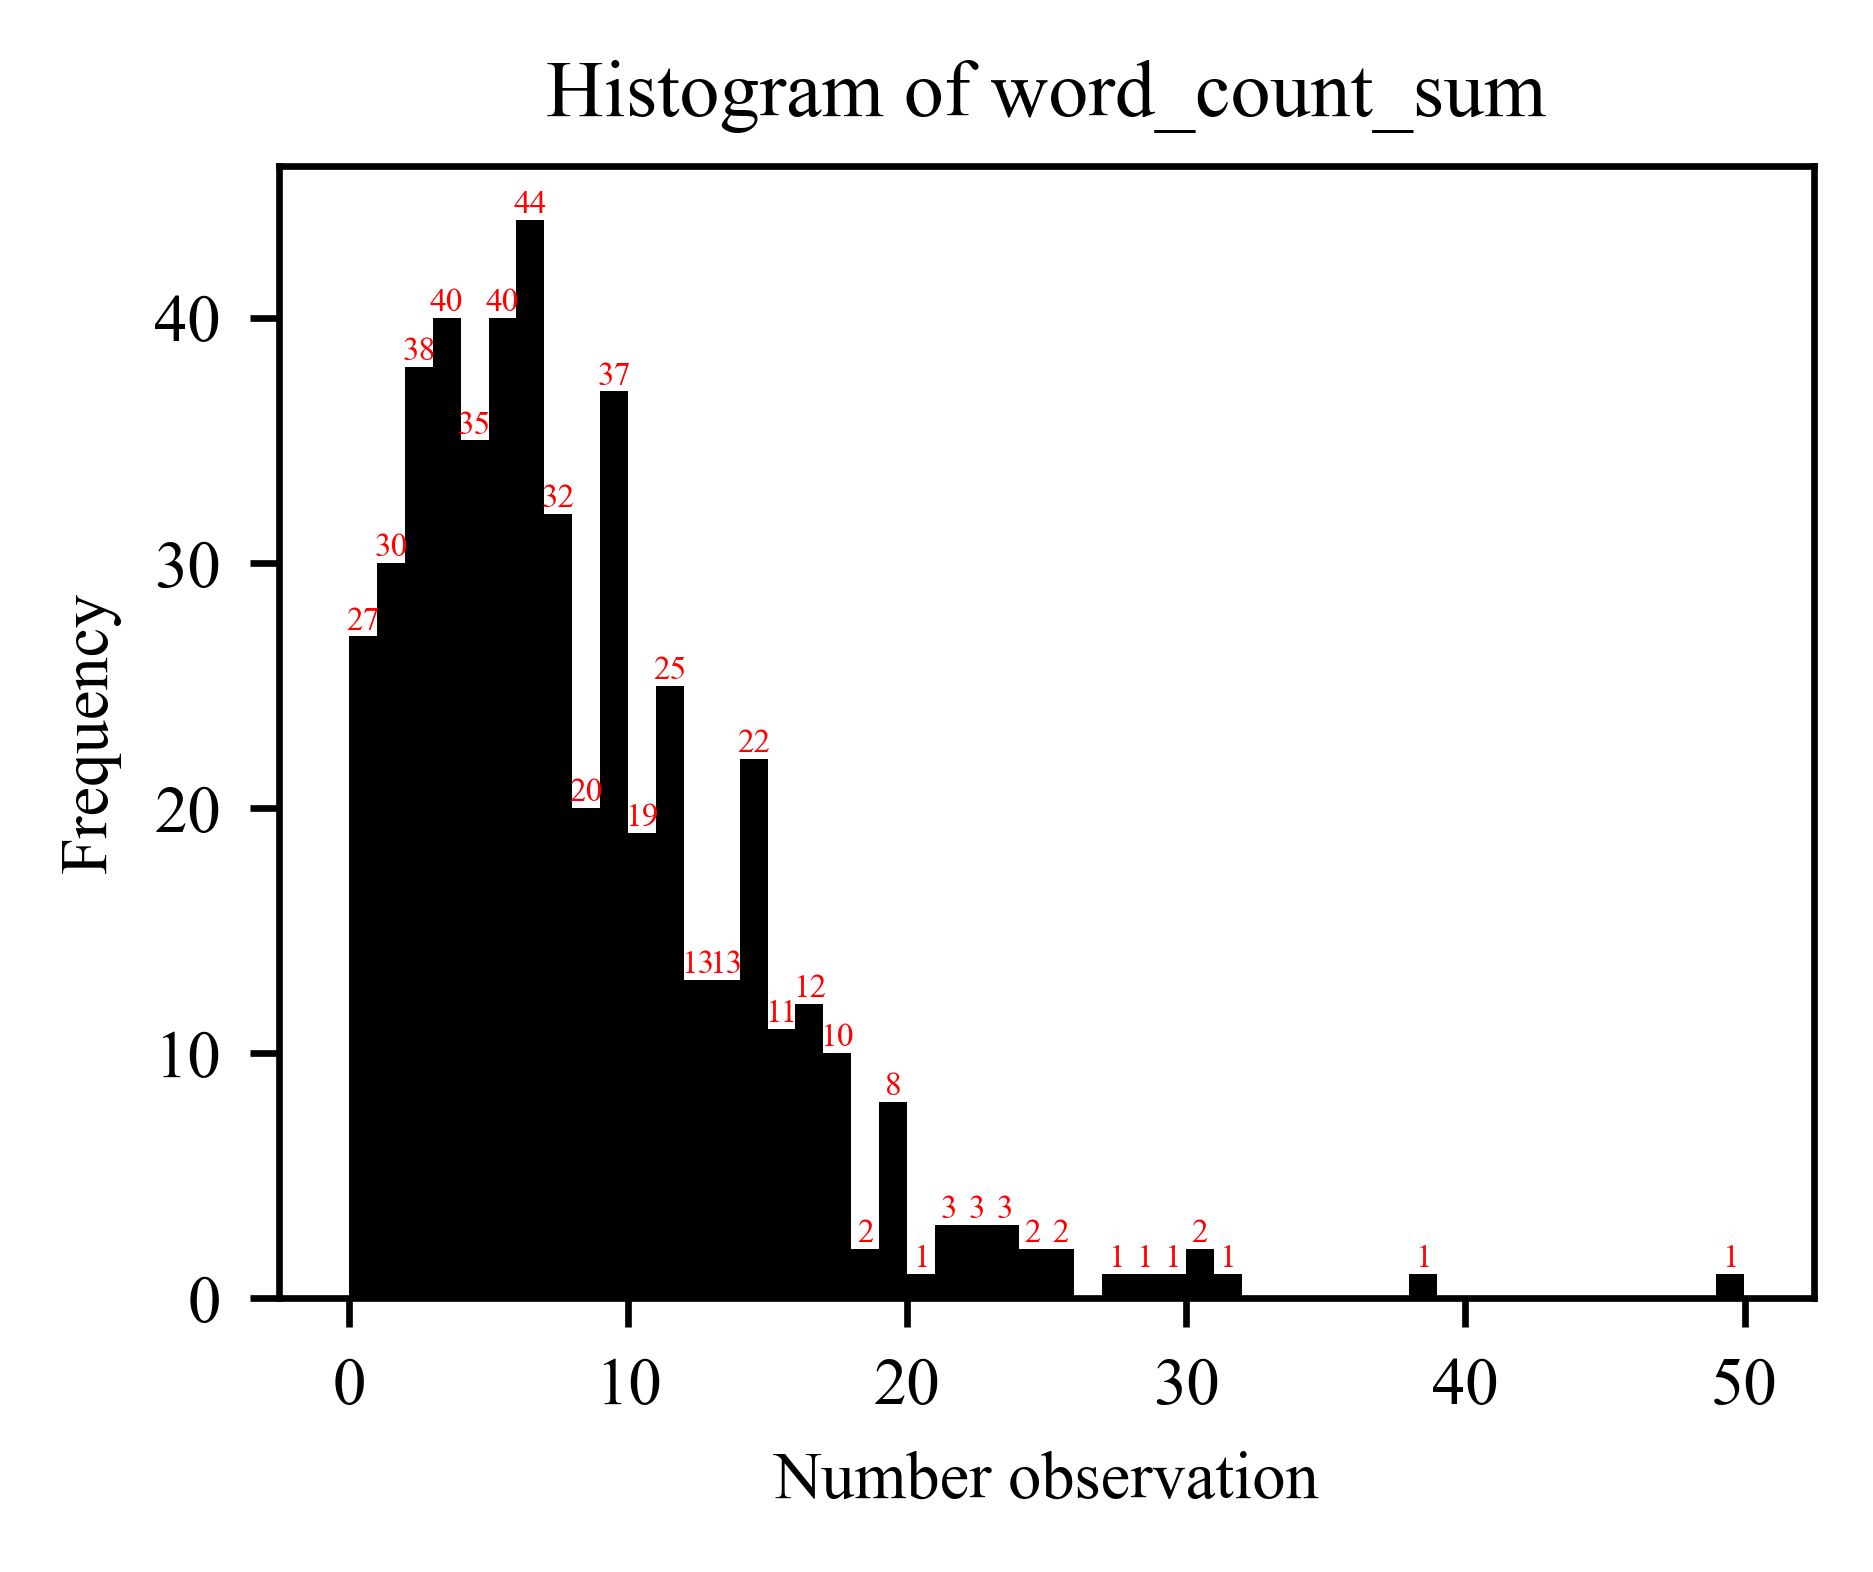

In [4]:
# 绘制histogram
bins = 50
range_min = df['word_count_sum'].min()
range_max = df['word_count_sum'].max()
# range_max = 10
range_step = (range_max - range_min) / bins
n, bins, patches = plt.hist(df['word_count_sum'], bins=bins, range=(range_min, range_max + range_step), alpha=1)
plt.xlabel('Number observation')
plt.ylabel('Frequency')
plt.title('Histogram of word_count_sum')
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    if n[i]>0:
        plt.text(x, y, str(int(n[i])), ha='center', va='bottom',color = "r",size = 4)
plt.show()


<Figure size 1980x1500 with 0 Axes>

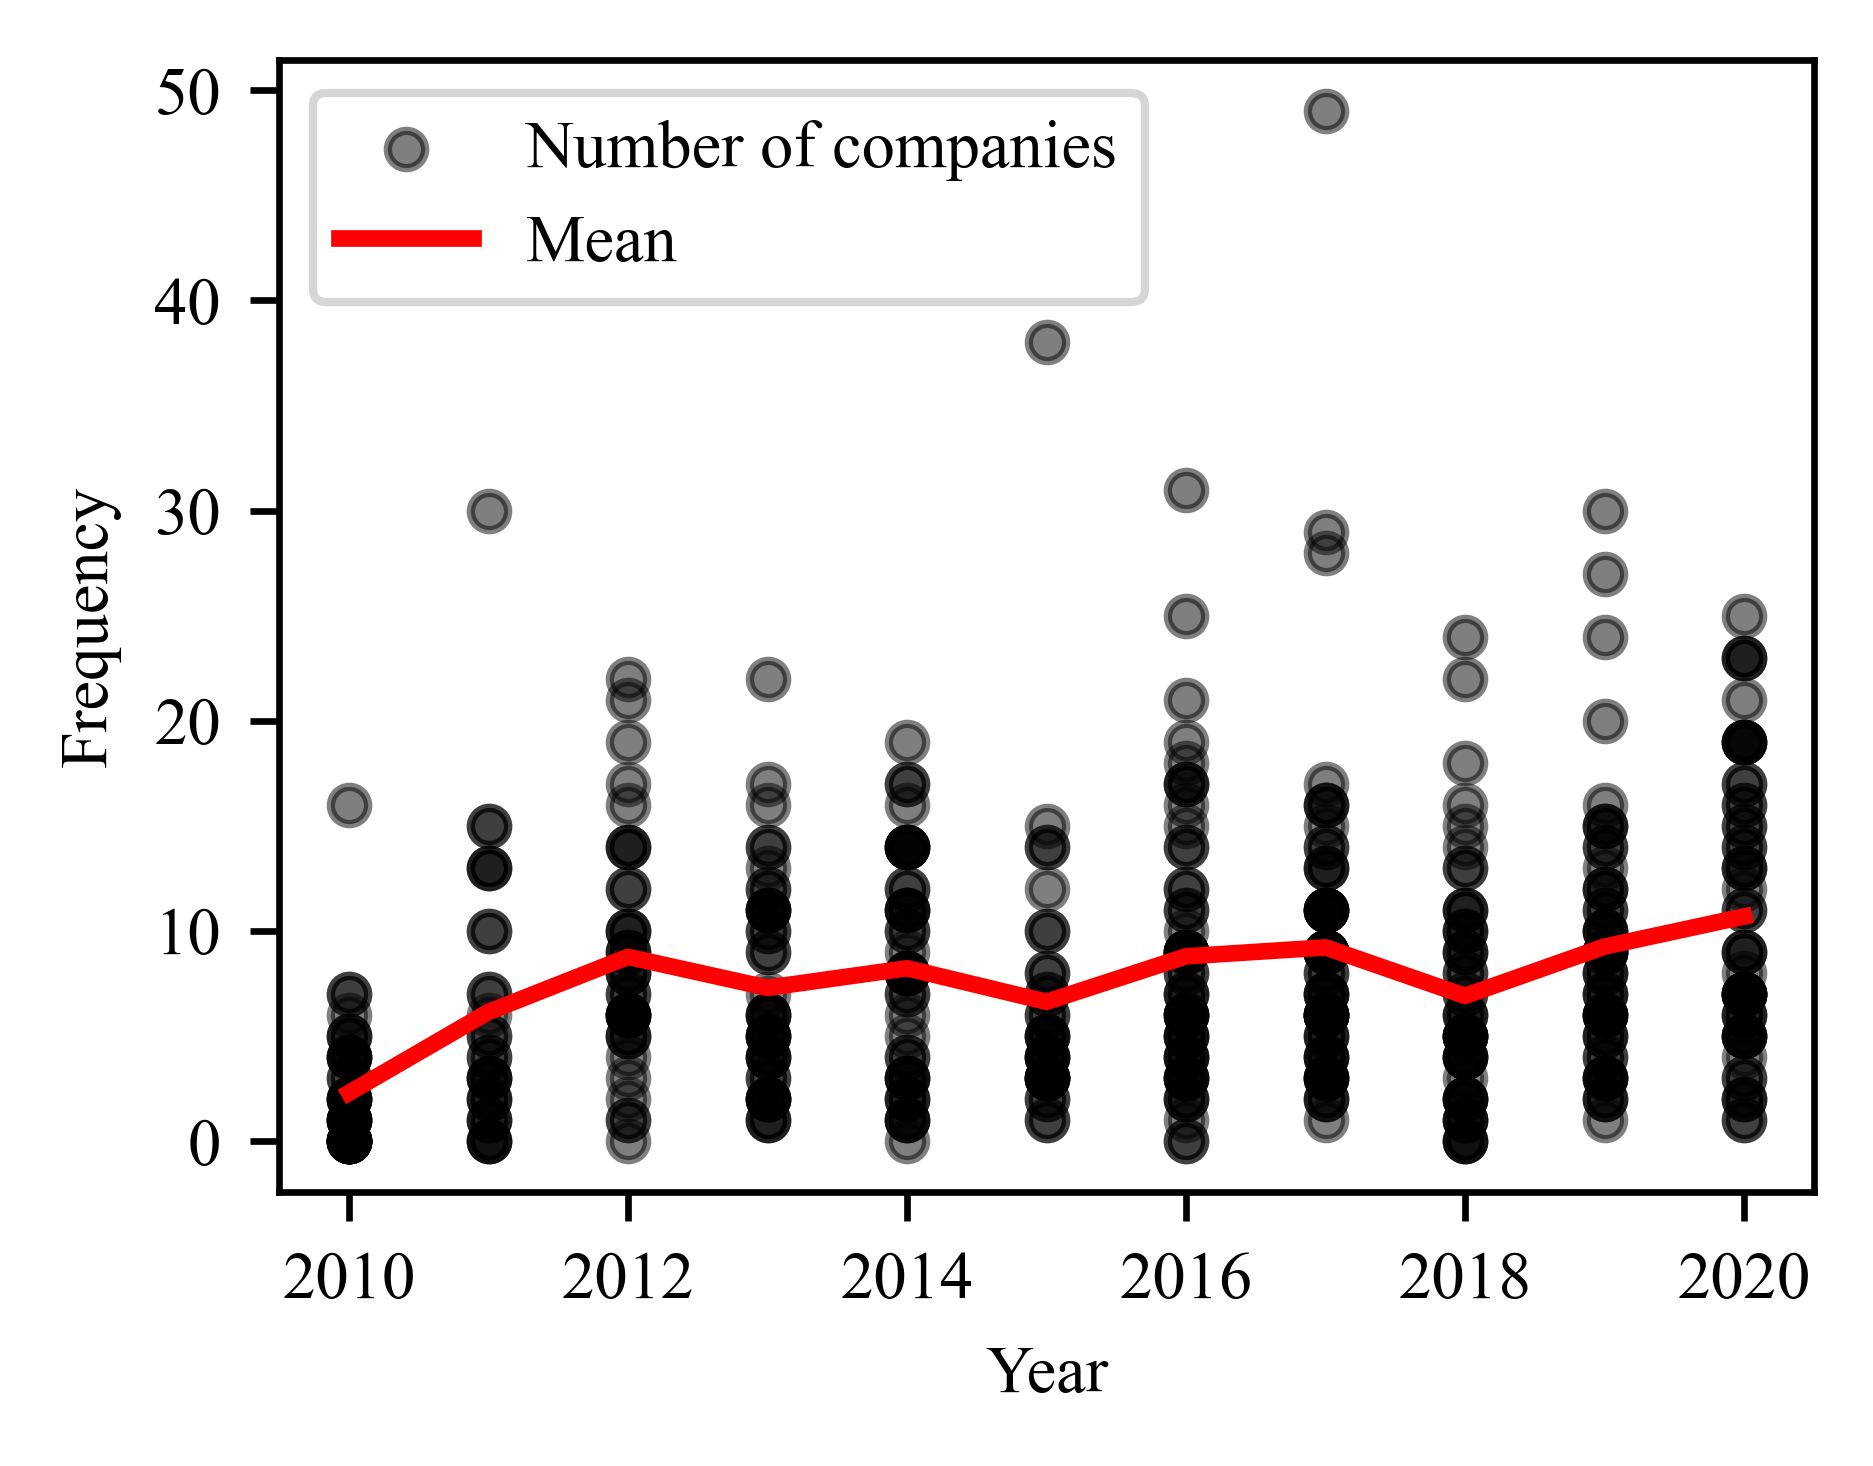

In [5]:
# 绘制年份分布图
fig = plt.figure()
ax1 = df.plot.scatter(x = "year",y="word_count_sum",alpha = 0.5, xlabel="Year",ylabel = "Frequency")
df_mean = df.groupby("year").mean()
df_mean = df_mean.reset_index()
ax2 = plt.plot(df_mean["year"], df_mean["word_count_sum"],color = "red",linewidth = 2,label = "Mean")
plt.legend(["Number of companies", "Mean"])
plt.show()

In [6]:
df_mean

,year,stkcd,word_count_sum
0,2010,193894.809524,2.285714
1,2011,197845.551724,6.137931
2,2012,284649.027027,8.756757
3,2013,315284.809524,7.285714
4,2014,243784.904762,8.214286
5,2015,257099.764706,6.617647
6,2016,377391.745455,8.781818
7,2017,382400.682540,9.206349
8,2018,403473.280000,6.900000
9,2019,335310.169811,9.245283


In [8]:
# 明细词频
df2 = pd.read_excel(r"C:\Users\Think\OneDrive\学习\py_ass\data\sample.xlsx")

def clean_text(text):
    # 删除非汉字项
    return re.sub('[^\u4e00-\u9fa5]+', '', text)

# 对“年报正文”列进行数据清洗和中文分词
df2['body'] = df2['body'].apply(lambda x: clean_text(x))
df2['sep'] = df2['body'].apply(lambda x: jieba.lcut(x))

# 词频统计函数
def count_words(text, dict_list):
    # 构造一个字典，键为词汇，值为该词汇出现的次数
    word_count = {}
    for word in text:
        if word in dict_list:
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] += 1
    # 返回每个词汇出现的频率
    total_count = sum(word_count.values())
    freq_dict = {}
    for word in word_count:
        # 计算组内相对频率
        # freq_dict[f'{word}'] = word_count[word] / total_count
        # 计算绝对频率
        freq_dict[f'{word}'] = word_count[word]
    return freq_dict

# 对“分词结果”列进行词频统计，将结果添加到数据框的最右侧
freq_df = pd.DataFrame(df2['sep'].apply(lambda x: count_words(x, dict_weather)).tolist())
df2 = pd.concat([df2, freq_df], axis=1)
df1 = df2
df["词袋法"] = df.iloc[:,5:].sum()
# df.to_excel(r"C:\Users\LZJ\OneDrive\学习\py_ass\sample明细词频.xlsx")
df.to_excel(r"C:\Users\Think\OneDrive\学习\py_ass\data\sample明细词频.xlsx")
print("over")

C:\Users\Think\AppData\Local\Temp\ipykernel_10160\1096895791.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df["词袋法"] = df.iloc[:,5:].sum()


over


In [9]:
del df1["body"]
del df1["sep"]
df1.to_excel(r"C:\Users\Think\OneDrive\学习\py_ass\df1.xlsx")

<AxesSubplot:xlabel='year'>

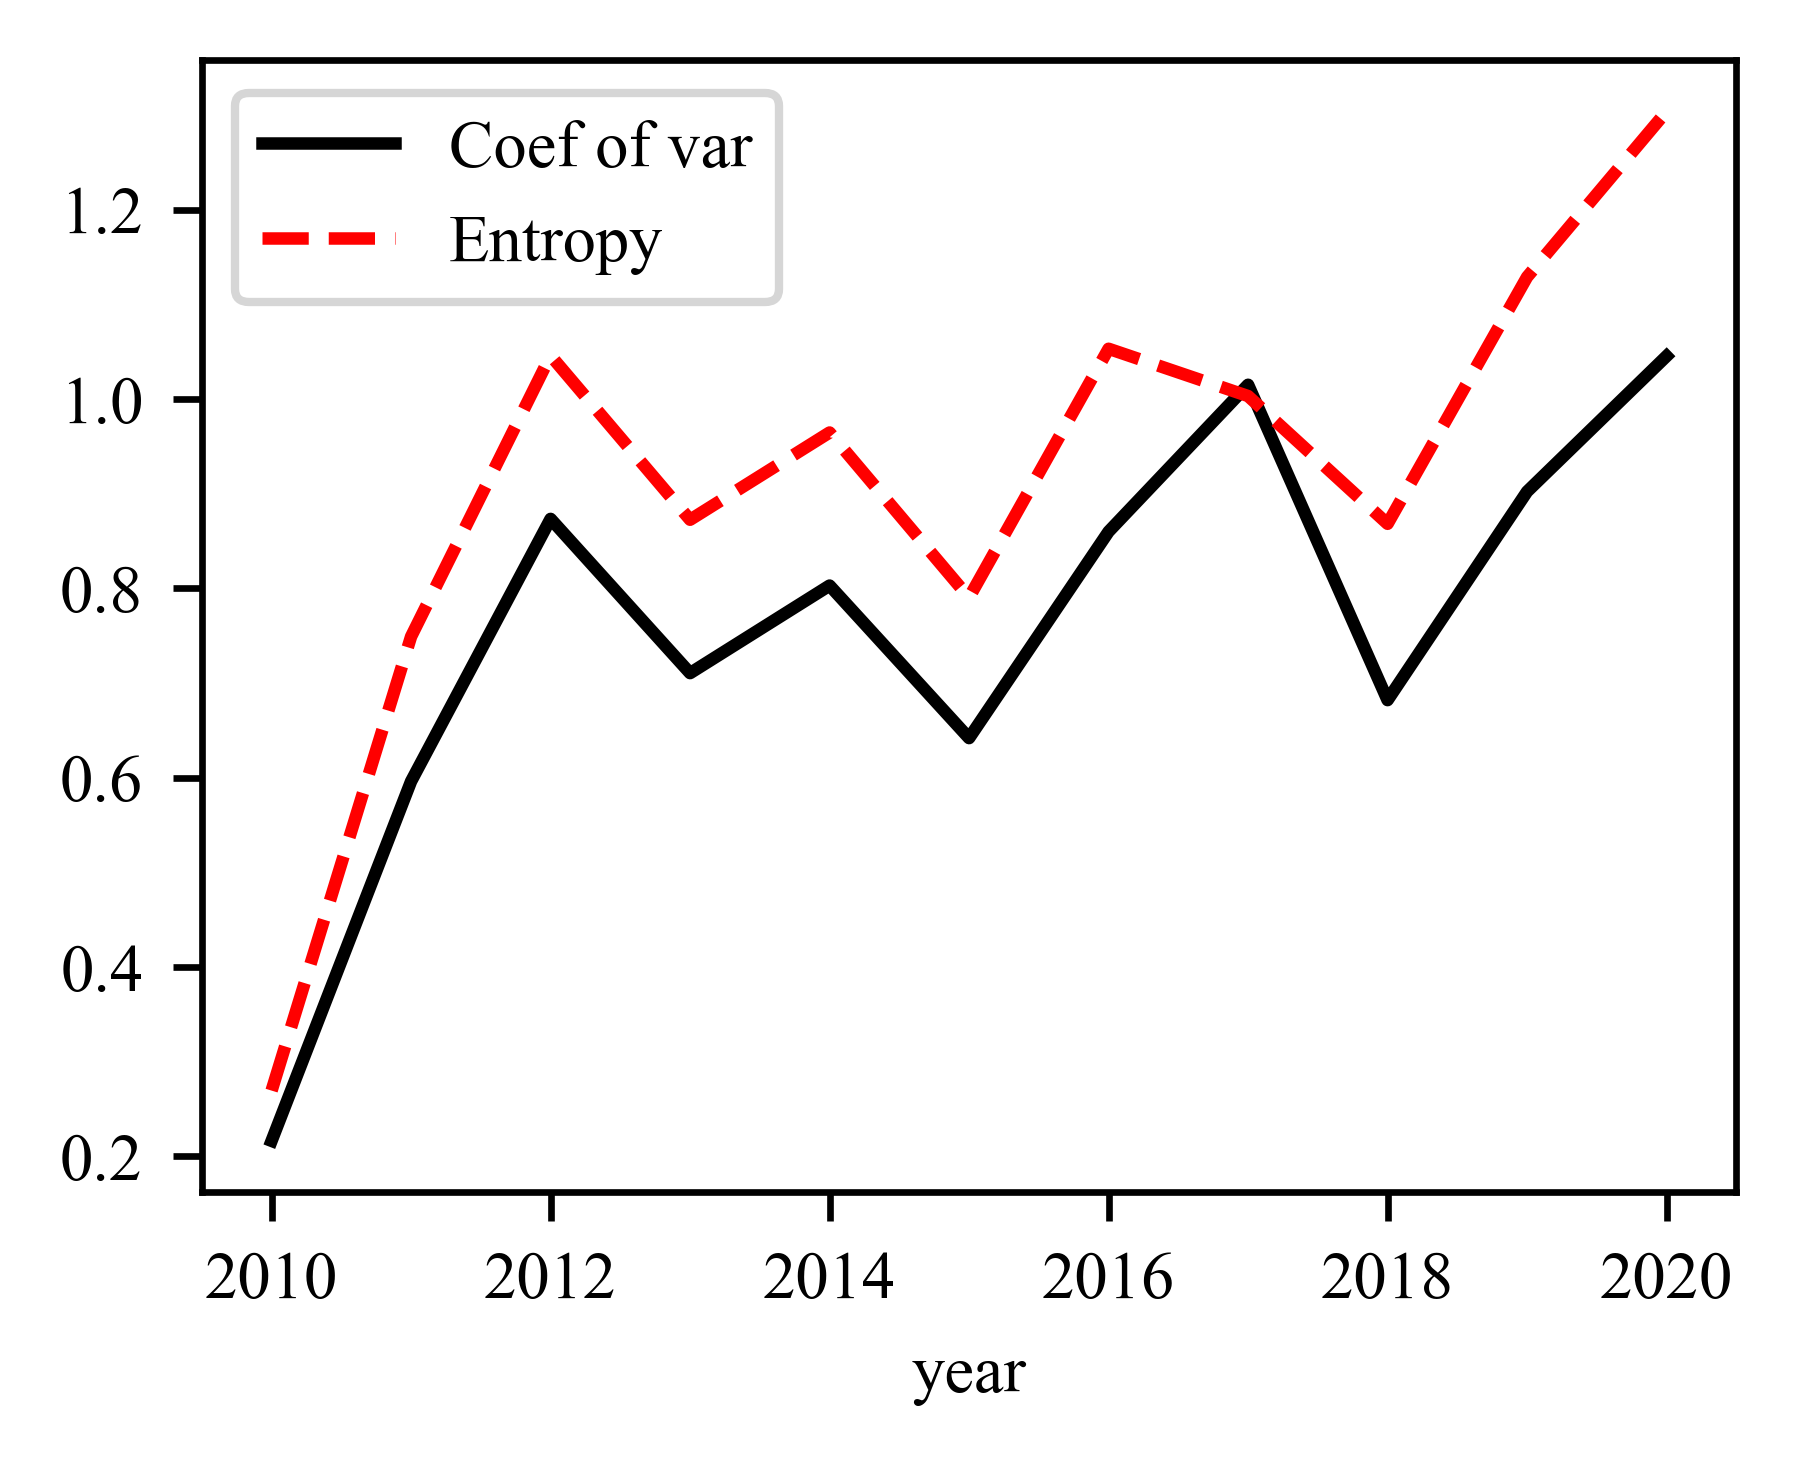

In [17]:
#IO
df1 = pd.read_excel(r"C:\Users\Think\OneDrive\学习\py_ass\df1.xlsx")
del df1["Unnamed: 0"]
# 提取需加权的列名
cols = df1.columns[3:]

# 熵值法计算权重d
maxmin = df1[cols].apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# p = df1[cols].apply(lambda x: x.value_counts()/len(x))
p = maxmin.apply(lambda x: x.value_counts()/len(x))
entropy = (-p*np.log(p)).sum()
weights_entropy = (1-entropy)/sum(1-entropy)

# 变异系数法计算权重
coefs_of_var = df1[cols].std() / df1[cols].mean()
weights_cv = coefs_of_var / coefs_of_var.sum()

# 计算加权综合指数（熵值法）
df1['weighted_index_entropy'] = (df1[cols] * weights_entropy).sum(axis=1)
df1['weighted_index_entropy'].fillna(df1['weighted_index_entropy'].mean(), inplace=True) # 如果存在缺失值，则替换为均值
df1['weighted_index_entropy'] = df1['weighted_index_entropy'].apply(lambda x: abs(x))

# 计算加权综合指数（变异系数法）
df1['weighted_index_cv'] = (df1[cols] * weights_cv).sum(axis=1)
df1['weighted_index_cv'].fillna(df1['weighted_index_cv'].mean(), inplace=True) # 如果存在缺失值，则替换为均值

df1[["stkcd","name","year","weighted_index_cv","weighted_index_cv"]].to_excel(r"C:\Users\Think\OneDrive\学习\py_ass\data\sample加权指数.xlsx")

df1_mean = df1.groupby("year").mean()
df1_mean = df1_mean.reset_index()

df1_mean.plot( x = "year", y = ["weighted_index_cv","weighted_index_entropy"],label = ["Coef of var","Entropy"])

In [ ]:
df2

,sample_id,timestamp,影响,冲击,温,低温,恶劣,高温,天气,雪,...,雾_weight,霾_weight,冷_weight,风_weight,干旱_weight,湿_weight,雷_weight,雨_weight,洪水_weight,composite_index
0,600556,ST慧球,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,5.039839
1,603963,大理药业,12.5801,1.520324,0.113508,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,19.253770
2,600653,申华控股,8.7093,0.760162,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,14.509301
3,603055,台华新材,4.8385,0.760162,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,10.638501
4,600538,国发股份,15.4832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,20.523039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,600654,ST中安,3.8708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,8.910639
496,2221,东华能源,6.7739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,11.813739
497,800,一汽轿车,9.6770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,14.716839
498,600050,中国联通,3.8708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317572,0.29615,0.291941,0.396416,0.119333,0.034791,0.0,0.0,0.0,8.910639
